# **Transfer Learning** -  
the reuse of a pre-trained model on a new problem.

* Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify cat may be useful to kick-start a model meant to identify dog.
* Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

Prepare the Data

In [8]:
import tensorflow as tf
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/aethe/.keras/datasets/flower_photos')

In [9]:
[i for i in list(data_dir.glob("*"))]

[WindowsPath('C:/Users/aethe/.keras/datasets/flower_photos/daisy'),
 WindowsPath('C:/Users/aethe/.keras/datasets/flower_photos/dandelion'),
 WindowsPath('C:/Users/aethe/.keras/datasets/flower_photos/LICENSE.txt'),
 WindowsPath('C:/Users/aethe/.keras/datasets/flower_photos/roses'),
 WindowsPath('C:/Users/aethe/.keras/datasets/flower_photos/sunflowers'),
 WindowsPath('C:/Users/aethe/.keras/datasets/flower_photos/tulips')]

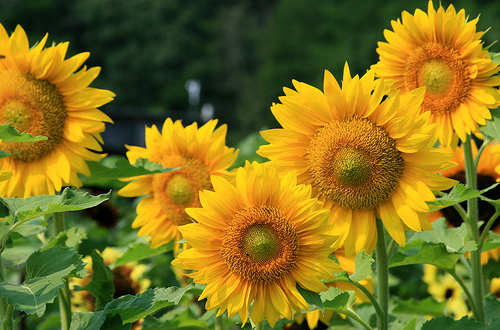

In [10]:
import PIL.Image as Image

sunflowers = list(data_dir.glob("sunflowers/*"))
Image.open(str(sunflowers[0]))


Load and normalize the data

In [15]:
%time

from tensorflow.keras.preprocessing.image import ImageDataGenerator

class Load_Data:
    
    # Create an instance of the ImageDataGenerator with some augmentations
    def data_generator(self, rescale=1./255):
        normalize_data = ImageDataGenerator(rescale=rescale, validation_split=0.2)
        return normalize_data
    
    # Load train and test data using ImageDataGenerator
    def load(self, directory: str, class_mode='categorical', target_size=(255, 255), shuffle=True, color_mode='rgb'):
        normalized_data = self.data_generator()

        train_data = normalized_data.flow_from_directory(
            directory=directory,
            target_size=target_size,
            color_mode=color_mode,
            class_mode=class_mode,
            batch_size=100,
            shuffle=shuffle,
            subset="training"
        )

        test_data = normalized_data.flow_from_directory(
            directory=directory,
            target_size=target_size,
            color_mode=color_mode,
            class_mode=class_mode,
            batch_size=20,
            shuffle=shuffle,
            seed=10,
            subset="validation"
        )

        return train_data, test_data


parent = Load_Data()
train_data, test_data = parent.load(data_dir)
print(train_data, test_data)


CPU times: total: 0 ns
Wall time: 0 ns
Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
<keras.src.preprocessing.image.DirectoryIterator object at 0x0000023CE2AA0B90> <keras.src.preprocessing.image.DirectoryIterator object at 0x0000023CE2AC0DD0>


In [14]:

x_train, y_train = next(train_data)
x_test, y_test = next(test_data)

# Display shapes of the divided data
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (100, 255, 255, 3)
Shape of y_train: (100, 5)
Shape of x_test: (20, 255, 255, 3)
Shape of y_test: (20, 5)


Train the Model using Functional API

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model

class MyModel:
    def base_model(self):
        base_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(255, 255, 3),
                   pooling='avg',
                   weights='imagenet')
        
        base_model.trainable = False
        
        # Inputs and outputs for model
        inputs = base_model.input

        x = base_model(inputs, training=False)
        x = tf.keras.layers.Dropout(0.2)(x)
        output = tf.keras.layers.Dense(5, activation="softmax")(x)
        model = Model(inputs=inputs, outputs=output)
        
        # model.summary(show_trainable=True)
        return model

parent = MyModel()
print(parent.base_model())


Train top layer

In [25]:
import numpy as np


class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
               self.stopped_epoch = epoch
               self.model.stop_training = True
               print("Restoring model weights from the end of the best epoch.")
               self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


# A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

    def on_test_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])
        )

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and loss is {:7.2f}.".format(
                epoch, logs["loss"], logs["loss"]
            )
        )

In [30]:

class train(MyModel):
    def train(self):
        model = self.base_model()
        train_data, test_data = Load_Data().load(data_dir)
        
        model.compile(
                    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )
        
        model.fit(
            train_data,
            epochs = 1,
            validation_data=test_data,
            callbacks=[LossAndErrorPrintingCallback(), EarlyStoppingAtMinLoss()]
        )

        return model
    
parent = train()
print(parent.train())
        

Model: "model_7"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_13 (InputLayer)       [(None, 255, 255, 3)]     0         N          
                                                                            
 resnet50 (Functional)       (None, 2048)              2358771   N          
                                                       2                    
                                                                            
 dropout_8 (Dropout)         (None, 2048)              0         Y          
                                                                            
 dense_8 (Dense)             (None, 5)                 10245     Y          
                                                                            
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________

Model Evaluate

In [ ]:
# Plot training & validation loss values
import matplotlib.pyplot as plt
model_history = train().train()

plt.plot(model_history.history['categorical_accuracy'])
plt.plot(model_history.history['val_categorical_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()